In [13]:
import torch
import os

class Konfigurasi:
    # --- Path dan Direktori ---
    # Ganti dengan path ke dataset 200 gambar Anda
    DATASET_PATH = '/kaggle/input/mask-dataset/data-mask' 
    MODEL_SAVE_PATH = 'best_mask_classifier.pth'

    # --- Pengaturan Model ---
    PRETRAINED_MODEL = 'resnet18'
    NUM_CLASSES = 2 # 'with_mask', 'without_mask'
    
    # --- Pengaturan Training ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 16
    EPOCHS = 10 # Tambah epoch untuk hasil lebih baik
    LEARNING_RATE = 0.001
    
    # --- Label Kelas ---
    CLASSES = ['Memakai Masker', 'Tanpa Masker']

# Inisialisasi konfigurasi
config = Konfigurasi()
print(f"Menggunakan device: {config.DEVICE}")

Menggunakan device: cuda


Menyimpan semua pengaturan di satu tempat agar mudah diubah.

In [14]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class FaceMaskDataset(Dataset):
    """Dataset untuk memuat gambar 'with_mask' dan 'without_mask'."""
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # Transformasi standar untuk model pretrained ResNet
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        self.images = []
        self.labels = []
        self.class_map = {'with_mask': 0, 'without_mask': 1}

        for class_name, label in self.class_map.items():
            class_path = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(class_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

def siapkan_data_loader(config):
    """Mempersiapkan dan membagi dataset menjadi train dan validation loader."""
    dataset = FaceMaskDataset(root_dir=config.DATASET_PATH)
    
    # Bagi dataset: 80% training, 20% validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    print(f"Jumlah data training: {len(train_dataset)}")
    print(f"Jumlah data validasi: {len(val_dataset)}")
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader

# Gunakan fungsi untuk membuat data loader
train_loader, val_loader = siapkan_data_loader(config)

Jumlah data training: 320
Jumlah data validasi: 80


Class untuk memuat, mengubah ukuran, dan melakukan normalisasi data gambar.

In [15]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

def bangun_model(config):
    """Membangun model ResNet18, membekukan layer, dan mengganti classifier."""
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    
    # 1. Bekukan semua layer feature extractor
    for param in model.parameters():
        param.requires_grad = False
        
    # 2. Ganti layer classifier (fully connected) terakhir
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, config.NUM_CLASSES)
    
    # Pindahkan model ke device yang sesuai (CPU/GPU)
    model = model.to(config.DEVICE)
    
    print("Model berhasil dibangun:")
    print("Layer feature extractor telah dibekukan (frozen).")
    print("Layer classifier terakhir diganti untuk 2 kelas.")
    return model

# Bangun modelnya
model = bangun_model(config)

Model berhasil dibangun:
Layer feature extractor telah dibekukan (frozen).
Layer classifier terakhir diganti untuk 2 kelas.


Fungsi untuk membangun model ResNet18 dan mengadaptasinya untuk tugas

In [16]:
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np

class Trainer:
    """Class untuk menangani proses training dan validasi model."""
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        # Optimizer hanya akan mengupdate parameter yang tidak dibekukan (model.fc)
        self.optimizer = optim.Adam(model.fc.parameters(), lr=config.LEARNING_RATE)
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train(self):
        """Mulai loop training untuk beberapa epoch."""
        best_val_acc = 0.0
        
        for epoch in range(self.config.EPOCHS):
            # Fase training
            self.model.train()
            train_loss, train_corrects = 0, 0
            for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.EPOCHS} [Training]"):
                inputs, labels = inputs.to(self.config.DEVICE), labels.to(self.config.DEVICE)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                loss.backward()
                self.optimizer.step()
                
                _, preds = torch.max(outputs, 1)
                train_loss += loss.item() * inputs.size(0)
                train_corrects += torch.sum(preds == labels.data)

            # Fase validasi
            self.model.eval()
            val_loss, val_corrects = 0, 0
            with torch.no_grad():
                for inputs, labels in tqdm(self.val_loader, desc=f"Epoch {epoch+1}/{self.config.EPOCHS} [Validasi]"):
                    inputs, labels = inputs.to(self.config.DEVICE), labels.to(self.config.DEVICE)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Hitung dan simpan metrik
            epoch_train_loss = train_loss / len(self.train_loader.dataset)
            epoch_train_acc = train_corrects.double() / len(self.train_loader.dataset)
            epoch_val_loss = val_loss / len(self.val_loader.dataset)
            epoch_val_acc = val_corrects.double() / len(self.val_loader.dataset)
            
            self.history['train_loss'].append(epoch_train_loss)
            self.history['train_acc'].append(epoch_train_acc.item())
            self.history['val_loss'].append(epoch_val_loss)
            self.history['val_acc'].append(epoch_val_acc.item())

            print(f"Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Val Acc: {epoch_val_acc:.4f}")
            
            # Simpan model dengan akurasi validasi terbaik
            if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
                torch.save(self.model.state_dict(), self.config.MODEL_SAVE_PATH)
                print(f"Model terbaik disimpan di {self.config.MODEL_SAVE_PATH}")
                
        return self.history

# Mulai training
trainer = Trainer(model, train_loader, val_loader, config)
history = trainer.train()

Epoch 1/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8023 Acc: 0.5250 | Val Loss: 0.5254 Val Acc: 0.7750
Model terbaik disimpan di best_mask_classifier.pth


Epoch 2/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4052 Acc: 0.8781 | Val Loss: 0.3120 Val Acc: 0.9375
Model terbaik disimpan di best_mask_classifier.pth


Epoch 3/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2589 Acc: 0.9438 | Val Loss: 0.2723 Val Acc: 0.9500
Model terbaik disimpan di best_mask_classifier.pth


Epoch 4/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1978 Acc: 0.9469 | Val Loss: 0.2289 Val Acc: 0.9500


Epoch 5/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1778 Acc: 0.9594 | Val Loss: 0.1650 Val Acc: 0.9500


Epoch 6/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1605 Acc: 0.9438 | Val Loss: 0.1609 Val Acc: 0.9625
Model terbaik disimpan di best_mask_classifier.pth


Epoch 7/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1177 Acc: 0.9656 | Val Loss: 0.1470 Val Acc: 0.9625


Epoch 8/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1538 Acc: 0.9656 | Val Loss: 0.1456 Val Acc: 0.9625


Epoch 9/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1142 Acc: 0.9781 | Val Loss: 0.1252 Val Acc: 0.9750
Model terbaik disimpan di best_mask_classifier.pth


Epoch 10/10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/10 [Validasi]:   0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.0942 Acc: 0.9781 | Val Loss: 0.1160 Val Acc: 0.9625


Class Trainer yang berisi semua logika untuk melatih dan memvalidasi model.

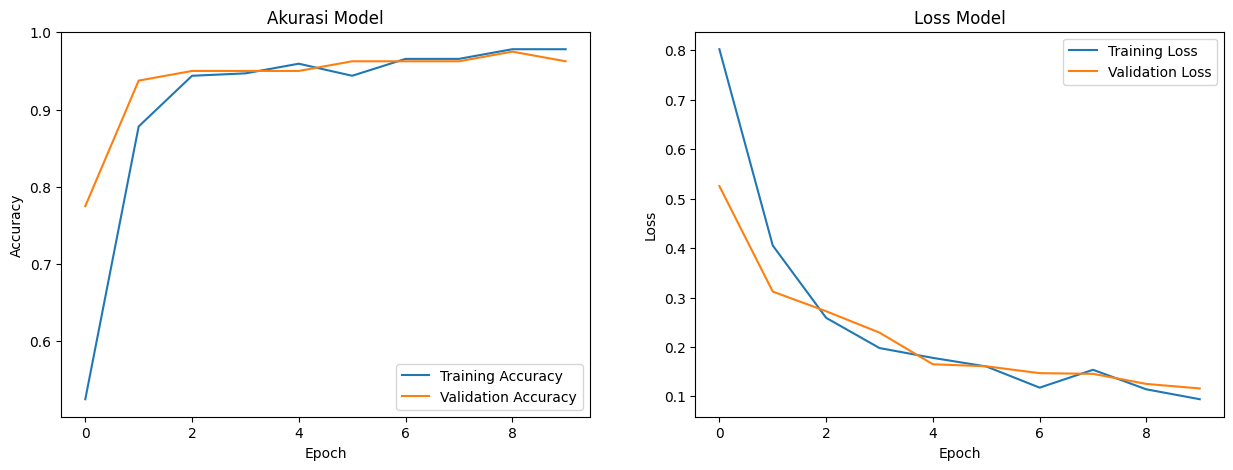

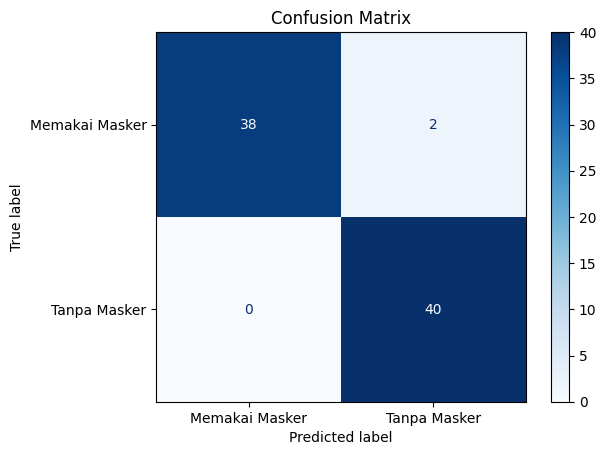

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_history(history):
    """Membuat plot grafik akurasi dan loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_acc'], label='Training Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Akurasi Model')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss Model')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

def tampilkan_confusion_matrix(model, dataloader, config):
    """Menampilkan confusion matrix dari data validasi."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.CLASSES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Panggil fungsi visualisasi
plot_history(history)

# Load model terbaik sebelum menampilkan confusion matrix
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
tampilkan_confusion_matrix(model, val_loader, config)

Fungsi-fungsi untuk memvisualisasikan hasil training (grafik loss & akurasi, confusion matrix).

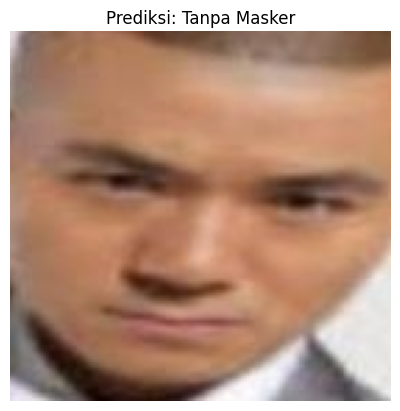

In [18]:
def prediksi_gambar(img_path, model, config):
    """Melakukan prediksi pada satu file gambar."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(config.DEVICE)
    
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_idx = torch.max(output, 1)
    
    prediksi_label = config.CLASSES[predicted_idx.item()]
    
    plt.imshow(image)
    plt.title(f'Prediksi: {prediksi_label}')
    plt.axis('off')
    plt.show()

# Ganti dengan path ke salah satu gambar Anda untuk diuji
CONTOH_GAMBAR_UJI = '/kaggle/input/mask-dataset/data-mask/without_mask/without_mask_106.jpg' 

# Lakukan prediksi
prediksi_gambar(CONTOH_GAMBAR_UJI, model, config)

Fungsi untuk melakukan inferensi pada satu gambar baru.